<a href="https://www.kaggle.com/code/minhjuniordinh/bellabeat-case-study?scriptVersionId=153967727" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="color:indianred"> Marathoning to Better Health: Understanding Habits of Watch Users: </h1>
### <span style="color: forestgreen; font-size:20px;" > A Case Study Finding Patterns in User Weight, Activity and Sleep </span>

***

<img src='https://miro.medium.com/v2/resize:fit:1400/1*SjEGKrjDp7skk4URhzW5Nw.png' height='300px' width='400px' class='left-aligned'>

# <span style="color:sienna">Who is Bellabeat?
Bellabeat is a tech company that focuses on health & wellbeing apparatuses. They collect data for users ranging from activity, stress and reproductive health to better inform women about their health and habits.

# <span style="color:sienna">Bellabeat's Time Watch
Time is a wellness watch designed to track user sleep, activity and stress. Data collected is displayed on the Bellabeat app for users.

# <span style="color:sienna">Business Task
To use publically available data to gain insights into how customers use non-Bellabeat devices. Based on these findings, provide recommendations for the Time watch.

***

In [1]:
# First, let's add the packages to be used
library(tidyverse)
library(ggplot2)
library(dplyr)
library(lubridate) # converting to date formats 
library(conflicted) # turns all conflicts into errors

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# Now we're importing various fitbit data
activity = read.csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv')
sleep = read.csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv')
weight = read.csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv')

hourly_intensity <- read.csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlyIntensities_merged.csv')
hourly_steps <- read_csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv', show_col_types = FALSE)

# Won't need to add daily steps, daily calories or daily intensity csv
# as they're already merged with activity csv

# <span style="color:forestgreen">Viewing imported data

In [3]:
head(activity)
head(weight)
head(sleep)

head(hourly_intensity)
head(hourly_steps)

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,1503960366,4/12/2016,13162,8.50,8.50,0,1.88,0.55,6.06,0,25,13,328,728,1985
2,1503960366,4/13/2016,10735,6.97,6.97,0,1.57,0.69,4.71,0,21,19,217,776,1797
3,1503960366,4/14/2016,10460,6.74,6.74,0,2.44,0.40,3.91,0,30,11,181,1218,1776
4,1503960366,4/15/2016,9762,6.28,6.28,0,2.14,1.26,2.83,0,29,34,209,726,1745
5,1503960366,4/16/2016,12669,8.16,8.16,0,2.71,0.41,5.04,0,36,10,221,773,1863
6,1503960366,4/17/2016,9705,6.48,6.48,0,3.19,0.78,2.51,0,38,20,164,539,1728


,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>
1,1503960366,5/2/2016 11:59:59 PM,52.6,115.9631,22,22.65,True,1.462234e+12
2,1503960366,5/3/2016 11:59:59 PM,52.6,115.9631,NA,22.65,True,1.462320e+12
3,1927972279,4/13/2016 1:08:52 AM,133.5,294.3171,NA,47.54,False,1.460510e+12
4,2873212765,4/21/2016 11:59:59 PM,56.7,125.0021,NA,21.45,True,1.461283e+12
5,2873212765,5/12/2016 11:59:59 PM,57.3,126.3249,NA,21.69,True,1.463098e+12
6,4319703577,4/17/2016 11:59:59 PM,72.4,159.6147,25,27.45,True,1.460938e+12


,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
,<dbl>,<chr>,<int>,<int>,<int>
1,1503960366,4/12/2016 12:00:00 AM,1,327,346
2,1503960366,4/13/2016 12:00:00 AM,2,384,407
3,1503960366,4/15/2016 12:00:00 AM,1,412,442
4,1503960366,4/16/2016 12:00:00 AM,2,340,367
5,1503960366,4/17/2016 12:00:00 AM,1,700,712
6,1503960366,4/19/2016 12:00:00 AM,1,304,320


,Id,ActivityHour,TotalIntensity,AverageIntensity
,<dbl>,<chr>,<int>,<dbl>
1,1503960366,4/12/2016 12:00:00 AM,20,0.333333
2,1503960366,4/12/2016 1:00:00 AM,8,0.133333
3,1503960366,4/12/2016 2:00:00 AM,7,0.116667
4,1503960366,4/12/2016 3:00:00 AM,0,0.000000
5,1503960366,4/12/2016 4:00:00 AM,0,0.000000
6,1503960366,4/12/2016 5:00:00 AM,0,0.000000


Id,ActivityHour,StepTotal
<dbl>,<chr>,<dbl>
1503960366,4/12/2016 12:00:00 AM,373
1503960366,4/12/2016 1:00:00 AM,160
1503960366,4/12/2016 2:00:00 AM,151
1503960366,4/12/2016 3:00:00 AM,0
1503960366,4/12/2016 4:00:00 AM,0
1503960366,4/12/2016 5:00:00 AM,0


I'd probably ask a stakeholder or the data owner what metrics were used to clasify light, active, etctera. It'd help me dive deeper into the analysis. Regardless, let's continue.

# <span style="color:forestgreen">Cleaning data

In [4]:
# Always check for: 
print('Data duplicates')
sum(duplicated(activity))
sum(duplicated(sleep))
sum(duplicated(weight))
sum(duplicated(hourly_intensity))
sum(duplicated(hourly_steps))

print('Data nulls')
sum(is.na(activity))
sum(is.na(sleep))
sum(is.na(weight))
sum(is.na(hourly_intensity))
sum(is.na(hourly_steps))

[1] "Data duplicates"


[1] 0

[1] 3

[1] 0

[1] 0

[1] 0

[1] "Data nulls"


[1] 0

[1] 0

[1] 65

[1] 0

[1] 0

In [5]:
# Now let's remove the duplicates
sleep <- sleep %>%
    distinct()
sum(duplicated(sleep))

[1] 0

Although weight has a lot of nulls, they're only in the Fat column which I won't be using anyway. I'm mostly interested in Kg and BMI. Id and Date are not null so I can merge them to the activity df later.

In [6]:
# Can see that date is a chr, need to change to date type
# Make a new, cleaned df (c_) to ensure changes made aren't done to original df 
# as.POSIXct is similar to as.Date but has time as well (need to specify format in both: "%m/%d/%Y [%I:%M:%S %p]")
# Standardise Date names to allow merging later 
# %I is 12hr clock (1-12), %M is minutes (0-59), %S is secs (0-59), %p is AM or PM
# Also separate Day and Month to analyse them later 

# activity 
c_activity <- activity %>% # using pipes to clean c_activity df
    rename(Date = ActivityDate) %>% #rename() part of dyplyr
    mutate(
        Date = as.Date(Date, format = '%m/%d/%Y'), # change chr to dttm type 
        Day = weekdays(Date), # extract Day
        Month = months(Date)) # extract Month
# don't use <- within mutate(), only use assignment operator = 

# sleep 
c_sleep <- sleep %>%
    rename(Date = SleepDay) %>% 
    mutate(
        Date = as.POSIXct(Date, format = '%m/%d/%Y %I:%M:%S %p'), # Converts Date to a dttm type the p specifies that it's in 12 hr format 
        Time = format(Date, format = '%H:%M:%S'), # New Time col made using format(), p removed for 24hr instead of 12hr format
        Day = weekdays(Date),
        Month = months(Date)
          ) 
# format() for creating Time col only worked because Date was a dttm type
# everyone seems to be sleeping exactly at 12 AM. . . weird. Could be error in data collection


# weight 
c_weight <- weight %>%
    mutate(
        Date = as.POSIXct(Date, format = '%m/%d/%Y %I:%M:%S %p'),
        Time = format(Date, format = '%H:%M:%S'), # Makes a 24hr Time col
        Day = weekdays(Date),
        Month = months(Date)
    )


# hourly_intensity
c_hourly_intensity <- hourly_intensity %>%
    mutate(
        Date = as.POSIXct(ActivityHour, format = '%m/%d/%Y %I:%M:%S %p'),  
        Time = format(Date, format = '%H:%M:%S'),
        Day = weekdays(Date),
        Month = months(Date)
        )

#hourly_steps 
c_hourly_steps <- hourly_steps %>%
    rename(Date = ActivityHour) %>%
    mutate(
        Date = as.POSIXct(Date, format = '%m/%d/%Y %I:%M:%S %p'),
        Time = format(Date, format = '%H:%M:%S'),
        Day = weekdays(Date),
        Month = months(Date)
        )


# <span style="color:forestgreen">Data exploration

In [7]:
# Was told that there'd be 30 fitbit participants, let's check
n_distinct(c_activity$Id)
n_distinct(c_hourly_intensity$Id)
n_distinct(c_hourly_steps$Id)
n_distinct(c_sleep$Id)
n_distinct(c_weight$Id)
# overall fairly low sample size to draw any decisive conclusions
# unfortunately weight has a very low sample size but we'll still check it out

[1] 33

[1] 33

[1] 33

[1] 24

[1] 8

In [8]:
print('activity summary (33n)')
c_activity %>%
    select(SedentaryMinutes, LightlyActiveMinutes, 
           FairlyActiveMinutes, VeryActiveMinutes, 
           Calories, TotalSteps) %>%
    summary() # creates min, max, quartiles, mean, median
print('')
# Appears that activity df has same data as intensity, calorie & step df so can omit those

print('sleep summary (24n)')
c_sleep %>%
    select(TotalMinutesAsleep, TotalTimeInBed) %>%
    summary()
print('')

print('weight summary (8n)')
    c_weight %>%
    select(WeightKg, BMI) %>%
    summary()

[1] "activity summary (33n)"


 SedentaryMinutes LightlyActiveMinutes FairlyActiveMinutes VeryActiveMinutes
 Min.   :   0.0   Min.   :  0.0        Min.   :  0.00      Min.   :  0.00   
 1st Qu.: 729.8   1st Qu.:127.0        1st Qu.:  0.00      1st Qu.:  0.00   
 Median :1057.5   Median :199.0        Median :  6.00      Median :  4.00   
 Mean   : 991.2   Mean   :192.8        Mean   : 13.56      Mean   : 21.16   
 3rd Qu.:1229.5   3rd Qu.:264.0        3rd Qu.: 19.00      3rd Qu.: 32.00   
 Max.   :1440.0   Max.   :518.0        Max.   :143.00      Max.   :210.00   
    Calories      TotalSteps   
 Min.   :   0   Min.   :    0  
 1st Qu.:1828   1st Qu.: 3790  
 Median :2134   Median : 7406  
 Mean   :2304   Mean   : 7638  
 3rd Qu.:2793   3rd Qu.:10727  
 Max.   :4900   Max.   :36019  

[1] ""
[1] "sleep summary (24n)"


 TotalMinutesAsleep TotalTimeInBed 
 Min.   : 58.0      Min.   : 61.0  
 1st Qu.:361.0      1st Qu.:403.8  
 Median :432.5      Median :463.0  
 Mean   :419.2      Mean   :458.5  
 3rd Qu.:490.0      3rd Qu.:526.0  
 Max.   :796.0      Max.   :961.0  

[1] ""
[1] "weight summary (8n)"


    WeightKg           BMI       
 Min.   : 52.60   Min.   :21.45  
 1st Qu.: 61.40   1st Qu.:23.96  
 Median : 62.50   Median :24.39  
 Mean   : 72.04   Mean   :25.19  
 3rd Qu.: 85.05   3rd Qu.:25.56  
 Max.   :133.50   Max.   :47.54  

Can see most users spend their time sedentary (991.2 mins, 16.52 hrs) on average. As intensity increases, time spent decreases.

Many users only get 419.2 minutes (~7 hrs) of sleep. Recommended is 7-9 hours for adults. Can look to improve sleep quality. 

The average user is slightly overweight (overweight range: 25.0-29.9) based on mean BMI (25.19) although there's a pretty low sample size. 

# <span style="color:forestgreen">Joining dataframes 

In [9]:
# Inner join that uses Id and Date - only returns matching records 
trimmed_sleep <- c_sleep %>% select(Id, Date, TotalMinutesAsleep, TotalTimeInBed)
trimmed_weight <- c_weight %>% select(Id, Date, WeightKg, BMI)

# Daily measured df:
activity_sleep <- merge(c_activity, trimmed_sleep, by = c('Id', 'Date'))
activity_weight <- merge(c_activity, trimmed_weight, by = c('Id', 'Date'))

# Hourly measured df:
# Note: c_activity is not presented as hourly data so need to do some extra calculations in the 'Average Total Intensity by Day' plot
activity_intensity <- merge(c_activity, c_hourly_intensity, by = c('Id', 'Date', 'Day', 'Month'))
hourly_int_steps <- merge(c_hourly_intensity, c_hourly_steps, by = c('Id', 'Date', 'Day', 'Month', 'Time'))
                                                    
n_distinct(c_sleep$Id)
n_distinct(activity_sleep$Id)

n_distinct(c_weight$Id)
n_distinct(activity_weight$Id)

n_distinct(c_activity$Id)
n_distinct(activity_intensity$Id)
n_distinct(hourly_int_steps$Id)
# no samples lost when merging so good 

[1] 24

[1] 24

[1] 8

[1] 8

[1] 33

[1] 33

[1] 33

# <span style="color:forestgreen">Plotting

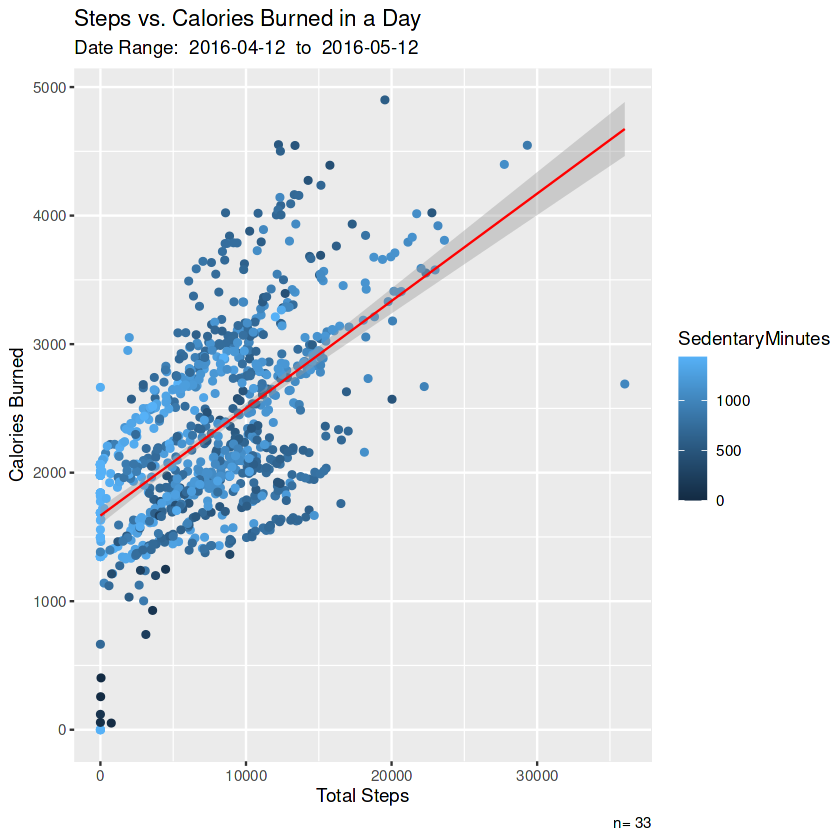

In [10]:
max_date = max(c_activity$Date)
min_date = min(c_activity$Date)
sample_size = n_distinct(c_activity$Id)

ggplot(data=c_activity) +
    geom_jitter(mapping=aes(x=TotalSteps,
                          y=Calories, colour=SedentaryMinutes)) +
    labs(title='Steps vs. Calories Burned in a Day',
         subtitle=paste("Date Range: ", min_date, " to ", max_date),
        caption=paste('n=',sample_size),
        x='Total Steps',
        y='Calories Burned') +
    geom_smooth(mapping=aes(x=TotalSteps,
                       y=Calories),
               colour = 'Red',
               linewidth = 0.5,
                method = 'lm', # specifies straight trendline
              formula = y ~ x)  # Specify the default formula here to remove output message 
# method = 'lm' tells R to fit straight line to estimate linear relationship b/w 2 varibles
# though don't use lm for everything since most things aren't linear when it comes to human biology

This viz shows that users spend a lot of minutes sedentary in a day. Also shows a trend of more steps being taken leading to more calories burned (likely to be a causal relationship). 

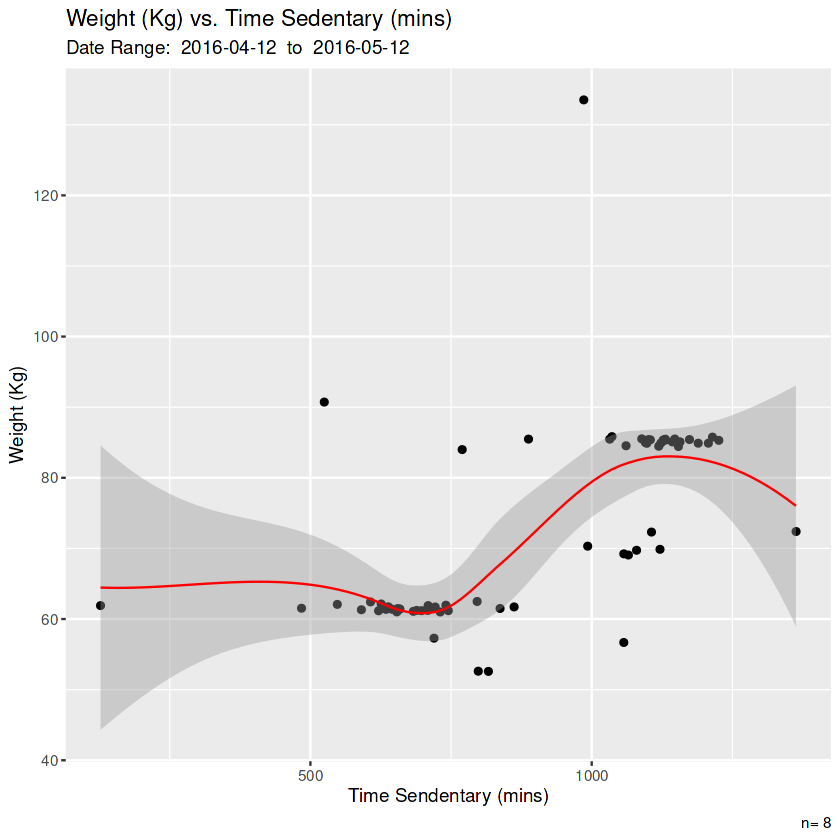

In [11]:
# Now let's see if time Sedentary could impact user weight 

max_date = max(activity_weight$Date)
min_date = min(activity_weight$Date)
sample_size = n_distinct(activity_weight$Id)

ggplot(data=activity_weight) +
    geom_jitter(mapping=aes(x=SedentaryMinutes,
               y=WeightKg)) +
    geom_smooth(mapping=aes(x=SedentaryMinutes,
               y=WeightKg), colour='Red', linewidth=0.5,
               method = 'loess', # method = 'loess', formula y ~ x is default but we add this to remove message
               formula = y ~ x) +
    labs(title = 'Weight (Kg) vs. Time Sedentary (mins)',
        subtitle = paste("Date Range: ", min_date, " to ", max_date),
        caption = paste('n=',sample_size),
        x='Time Sendentary (mins)',
        y='Weight (Kg)')

There's only 8 samples here so would expect larger variance. However, this preliminary data would suggest greater time sedentary is associated with greater weight.

<span style="color:indianred">**Next, we'll answer: how active are users day by day?**

Day,mean_sedentary_mins,mean_light_mins,mean_fair_mins,mean_active_mins,min_date,max_date,sample_size
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<date>,<int>
Monday,1027.9417,192.0583,14.00000,23.10833,2016-04-18,2016-05-09,32
Tuesday,1007.3618,197.3421,14.33553,22.95395,2016-04-12,2016-05-10,33
Wednesday,989.4800,189.8533,13.10000,20.78000,2016-04-13,2016-05-11,33
Thursday,961.9932,185.4218,11.95918,19.40816,2016-04-14,2016-05-12,33
Friday,1000.3095,204.1984,12.11111,20.05556,2016-04-15,2016-05-06,33
Saturday,964.2823,207.1452,15.20161,21.91935,2016-04-16,2016-05-07,32
Sunday,990.2562,173.9752,14.52893,19.98347,2016-04-17,2016-05-08,32


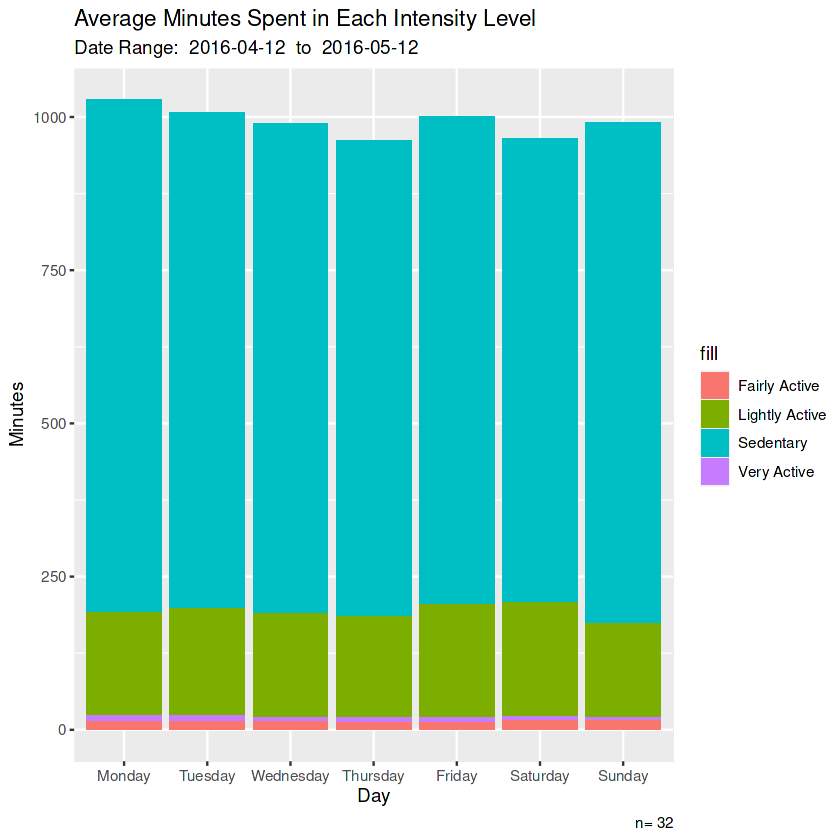

In [12]:
# Let's get the average mins spent per day for each level of activeness 
# Reordering the Days so it displays nicer on x-axis
day_order <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")

grouped_day_intensity <- c_activity %>%
  mutate(Day = factor(weekdays(Date), levels = day_order)) %>% # Have to change Day as a factor before summarise() to avoid a million Monday rows 
  group_by(Day) %>%
  summarise(mean_sedentary_mins = mean(SedentaryMinutes),
            mean_light_mins = mean(LightlyActiveMinutes),
            mean_fair_mins = mean(FairlyActiveMinutes),
            mean_active_mins = mean(VeryActiveMinutes),
            min_date = min(Date),
            max_date = max(Date),
            sample_size = n_distinct(Id)) %>%
  View()

# stat='Identity' - height of bars directly proportional to y value 
# position='Dodge' should move bars side to side instead of them stacking 
# doesn't do this in output for some reason
ggplot(data = grouped_day_intensity) +
  geom_bar(mapping = aes(x = Day, y = mean_sedentary_mins, fill = 'Sedentary'), stat = 'identity', position = 'dodge') +
  geom_bar(mapping = aes(x = Day, y = mean_light_mins, fill = 'Lightly Active'), stat = 'identity', position = 'dodge') +
  geom_bar(mapping = aes(x = Day, y = mean_active_mins , fill = 'Very Active'), stat = 'identity', position = 'dodge') +
  geom_bar(mapping = aes(x = Day, y = mean_fair_mins , fill = 'Fairly Active'), stat = 'identity', position = 'dodge') +
  labs(title = 'Average Minutes Spent in Each Intensity Level',
       y = 'Minutes',
       subtitle = paste("Date Range: ", min(grouped_day_intensity$min_date), " to ", max(grouped_day_intensity$max_date)),
       caption = paste('n=', grouped_day_intensity$sample_size))

We see across all days, most time is spent sedentary. Interestingly, the least amount of light activity is done during Sunday.
- It's probably easier to encourage users to spend more time doing light intensity workouts rather than the fairy or very active ones.

<span style="color:indianred">**Next, let's check out which days users spend the most & least time having intensity actitivites**

Day,mean_steps,sample_size,mean_total_int,min_date,max_date
<fct>,<dbl>,<int>,<dbl>,<date>,<date>
Monday,7798.404,32,290.6928,2016-04-18,2016-05-09
Tuesday,8233.340,33,298.6267,2016-04-12,2016-05-10
Wednesday,7633.415,33,282.2081,2016-04-13,2016-05-11
Thursday,7754.363,33,286.2455,2016-04-14,2016-05-12
Friday,7502.356,33,290.2342,2016-04-15,2016-05-06
Saturday,8314.140,32,309.6206,2016-04-16,2016-05-07
Sunday,6943.884,32,263.6105,2016-04-17,2016-05-08


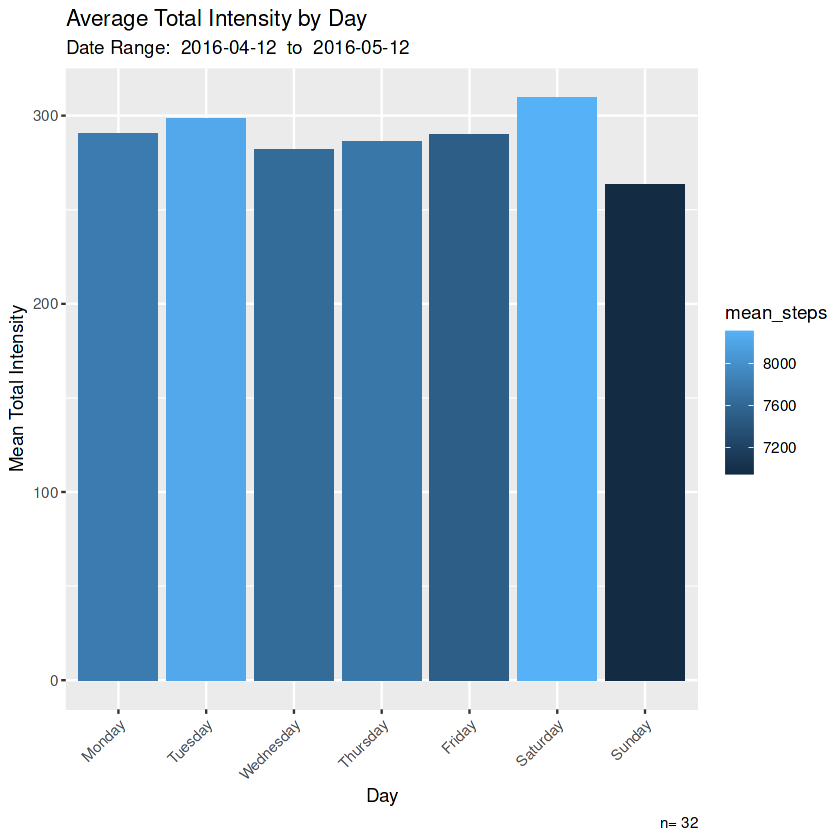

In [13]:
# Reordering the Days so it displays nicer on x-axis
day_order <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")

grouped_day_intensity <- activity_intensity %>%
    mutate(Day = factor(Day, levels = day_order)) %>% # factor day before running summarise so you only have 1 row each day
    group_by(Day) %>%
    drop_na() %>%
    summarise(mean_steps = mean(TotalSteps),
              sample_size=n_distinct(Id), 
              mean_total_int = mean(TotalIntensity)*24,
# since Total Intensity is by hour and not by day, y-axis won't be accurate, best thing I could come up with is multiplying by 24 (24hrs in a day)
              min_date = min(Date), 
              max_date = max(Date)) %>%
    View()

ggplot(data = grouped_day_intensity) + 
  geom_bar(aes(x = Day, y = mean_total_int, fill = mean_steps), stat = "identity") + 
# stat='identity' means bar height should be values directly w/ no transformation (e.g. counting, binning)
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
#vjust (vertical adjust) and hjust move axis title 
  labs(title="Average Total Intensity by Day", x = "Day", y = "Mean Total Intensity",
       subtitle=paste("Date Range: ", min_date, " to ", max_date), caption=paste('n=',grouped_day_intensity$sample_size))

Looks like users spend more time active on Tuesdays and Saturdays.
- Least time active was on Sundays (also had the lowest lightly active minutes)
- Adjust strategy to encourage users to spend more time doing light intensity workouts during Sunday

<span style="color:indianred">**Now that we've looked at what activity is like on different days, let's dive deeper into the times**

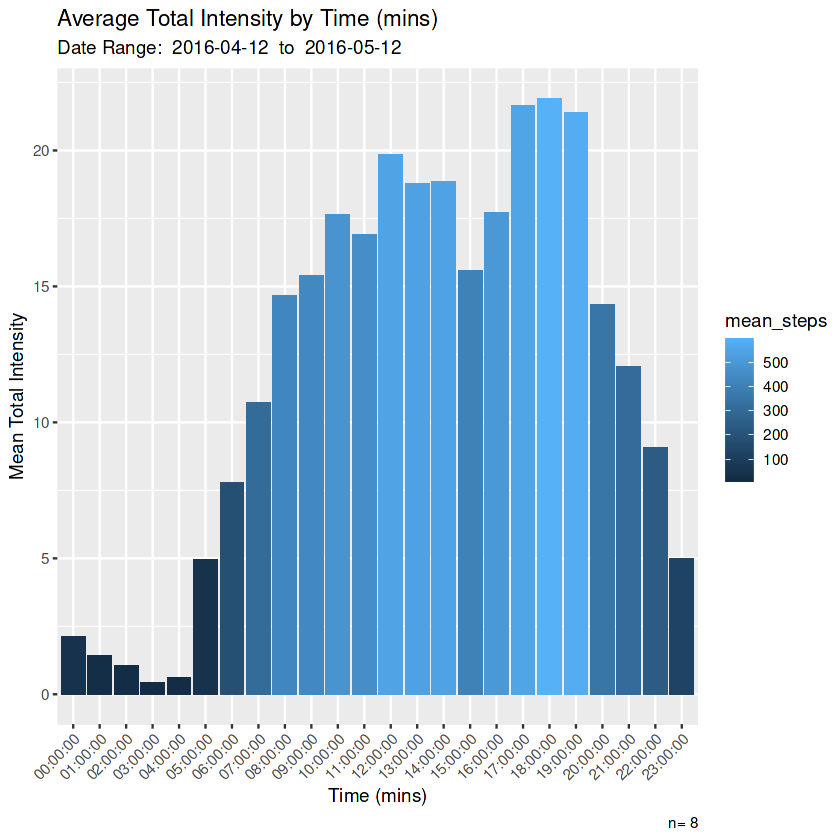

In [14]:
# Since we're doing by the hour, have to use our hourly df (hourly intensity + hourly steps)
grouped_time_intensity <- hourly_int_steps %>%
  drop_na() %>%
  group_by(Time) %>%
  summarise(mean_total_int = mean(TotalIntensity),
            mean_steps = mean(StepTotal),
            sample_size = n_distinct(Id),
            min_date = min(Date),
            max_date = max(Date)) 

ggplot(data = grouped_time_intensity) + 
  geom_bar(aes(x = Time, y = mean_total_int, fill = mean_steps), stat = "identity") + 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  labs(title = "Average Total Intensity by Time (mins)", 
       x = "Time (mins)", y = "Mean Total Intensity",
       subtitle = paste('Date Range: ',min_date, ' to ', max_date),
       caption = paste('n=', sample_size))

Majority of time spent working out from pool of users is between 5 AM - 11 PM. Activity peaks between 5 PM - 7 PM. 

Workout times would likely depend on each user. Would probably be best to create a personalised workout reminder scheuldule.
- Schedule can be learnt based on user heartrate (a likely indicator of working out).
- Based on this schedule, can send workout reminders.

<span style="color:indianred">**Let's next check the relationship between Sedentary Minutes and Time Asleep**

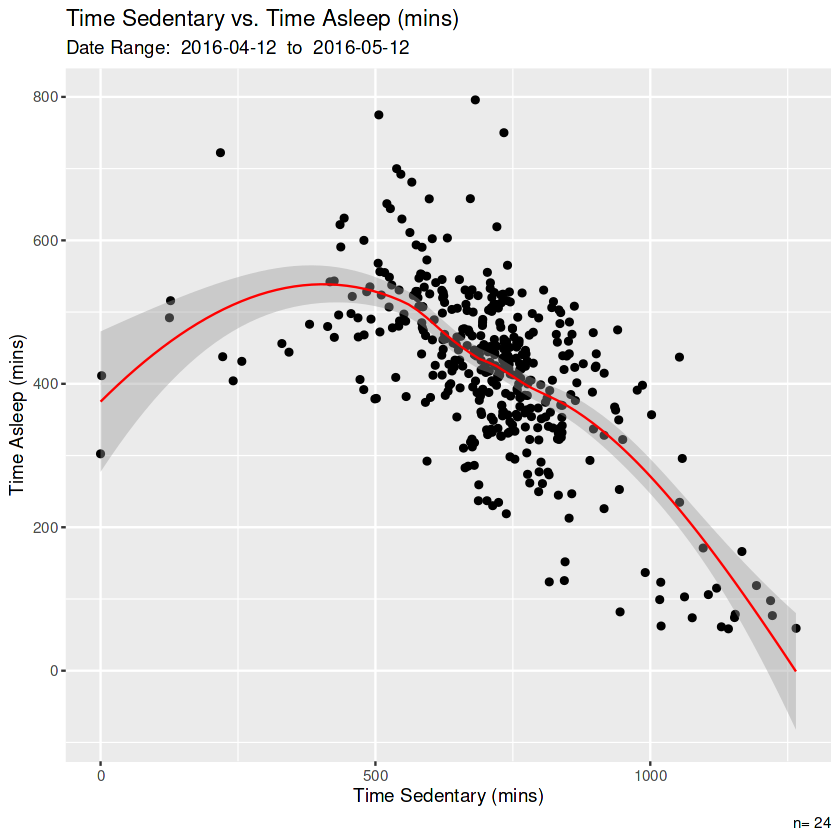

In [15]:
max_date = max(activity_sleep$Date)
min_date = min(activity_sleep$Date)
sample_size = n_distinct(activity_sleep$Id)

ggplot(data=activity_sleep) +
    geom_jitter(mapping=aes(x=SedentaryMinutes,
                          y=TotalMinutesAsleep)) +
    labs(title=paste('Time Sedentary vs. Time Asleep (mins)'),
         subtitle=paste("Date Range: ", min_date, " to ", max_date),
        caption=paste('n=',sample_size),
        x='Time Sedentary (mins)',
        y='Time Asleep (mins)') +
    geom_smooth(mapping=aes(x=SedentaryMinutes,
                       y=TotalMinutesAsleep),
               colour = 'Red',
               linewidth = 0.5,
               method = 'loess', 
               formula = y ~ x)

Can see that too much time spent sedentary reduces sleep time. Ideally want watch users to not be too sedentary if sleep needs to be improved. Could setup exercise reminders during the times when people are most active *(5AM - 11PM, 5 PM - 7PM peak)*. Alternatively, could remind users to move if watch detects they're sedentary for an extended period.

<span style="color:indianred">**Next, we also see that users that spend more time sedentary also spend less time in bed**

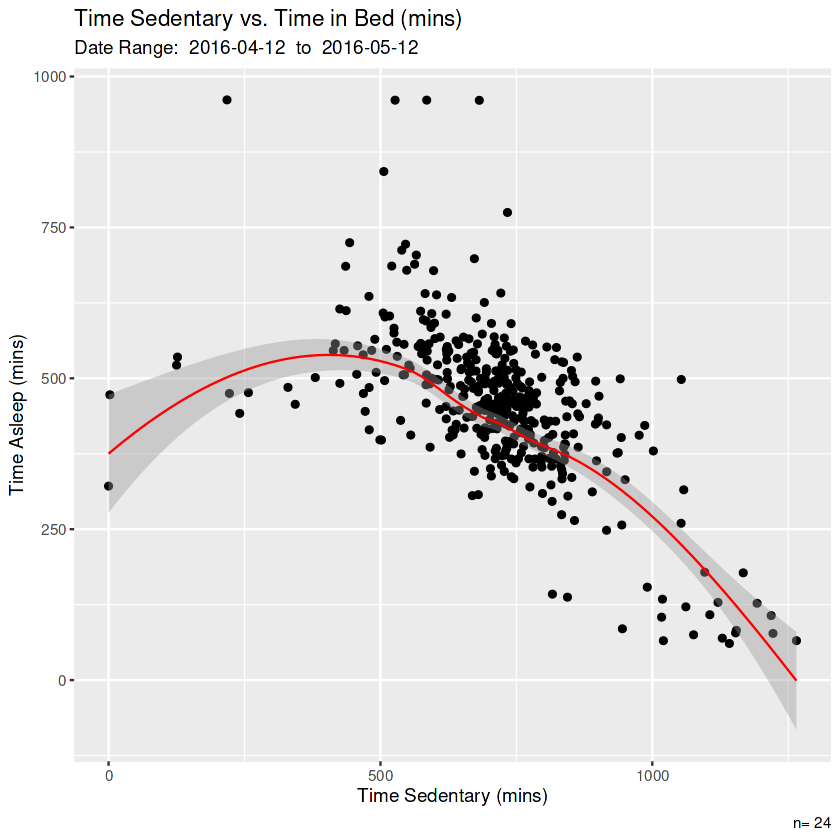

In [16]:
max_date = max(activity_sleep$Date)
min_date = min(activity_sleep$Date)
sample_size = n_distinct(activity_sleep$Id)

ggplot(data=activity_sleep) +
    geom_jitter(mapping=aes(x=SedentaryMinutes,
                          y=TotalTimeInBed)) +
    labs(title=paste('Time Sedentary vs. Time in Bed (mins)'),
         subtitle=paste("Date Range: ", min_date, " to ", max_date),
        caption=paste('n=',sample_size),
        x='Time Sedentary (mins)',
        y='Time Asleep (mins)') +
    geom_smooth(mapping=aes(x=SedentaryMinutes,
                       y=TotalMinutesAsleep),
               colour = 'Red',
               linewidth = 0.5,
               method = 'loess', 
               formula = y ~ x)

Highlights the importance of having the watch send stern reminders for bedtime, especially if users are sedentary. 
- Could sedentary users be using their phones instead of sleeping? 
- We'll need more data to see
- If sedentary users are using their phone too much, we could have bellabeat connect to the phone to gauge screentime?

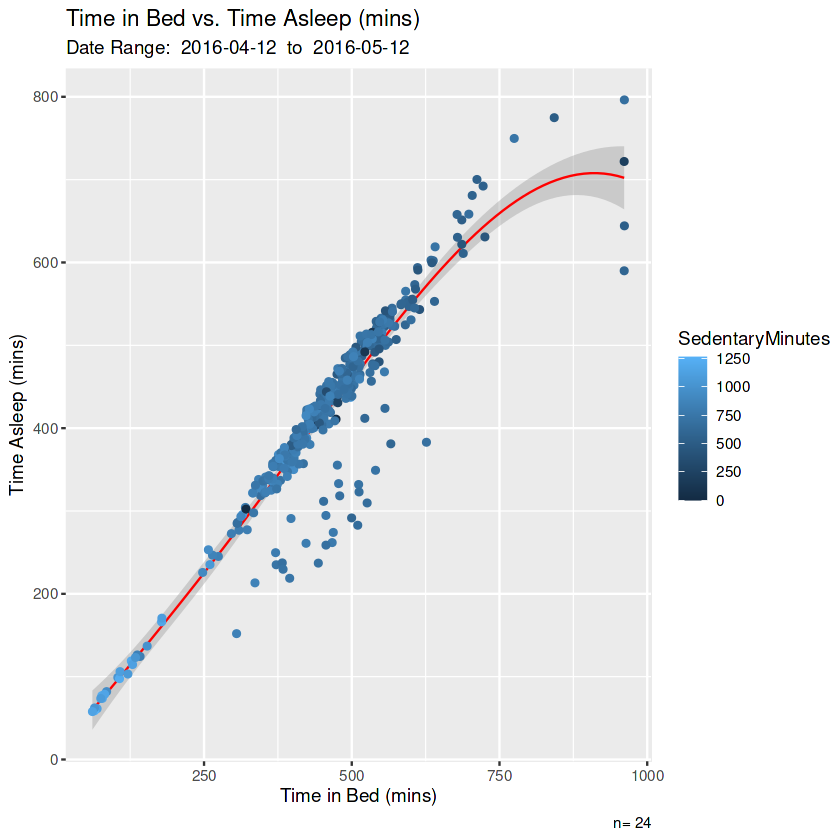

In [17]:
# Let's dive deeper into sleep data 
# View(c_sleep)
# strangely are users slept at the exact same time - midnight 12 AM

# Let's check out relationship b/w TotalMinutes Asleep and TotalTimeInBed

max_date = max(activity_sleep$Date)
min_date = min(activity_sleep$Date)
sample_size = n_distinct(activity_sleep$Id)

# We'll use our merged df to add SedentaryMinutes as a colour
ggplot(data=activity_sleep) +
    geom_smooth(mapping=aes(x=TotalTimeInBed,
                            y=TotalMinutesAsleep),
    colour='Red',
    linewidth=0.5,
    method = 'loess', 
    formula = y ~ x) +
labs(title='Time in Bed vs. Time Asleep (mins)',
    subtitle=paste("Date Range: ", min_date, " to ", max_date),
        caption=paste('n=',sample_size),
    x='Time in Bed (mins)',
    y='Time Asleep (mins)') +
geom_jitter(mapping=aes(x=TotalTimeInBed,
                            y=TotalMinutesAsleep,colour=SedentaryMinutes)) 

Can see that total time in bed correlates with the total amount of sleep. If users want more sleep, could suggest them to set a reminder to sleep earlier.

The average amount of sleep across all users and all days is only 7hrs (420 mins). Looking at the viz, a decent portion of days had even less than 420 minutes.

Day,mean_total_mins_asleep,mean_total_mins_in_bed,sample_size,min_date,max_date
<fct>,<dbl>,<dbl>,<int>,<dttm>,<dttm>
Monday,419.5000,457.3478,16,2016-04-18,2016-05-09
Tuesday,404.5385,443.2923,18,2016-04-12,2016-05-10
Wednesday,434.6818,470.0303,19,2016-04-13,2016-05-11
Thursday,401.2969,434.8750,19,2016-04-14,2016-05-12
Friday,405.4211,445.0526,21,2016-04-15,2016-05-06
Saturday,419.0702,459.8421,21,2016-04-16,2016-05-07
Sunday,452.7455,503.5091,20,2016-04-17,2016-05-08


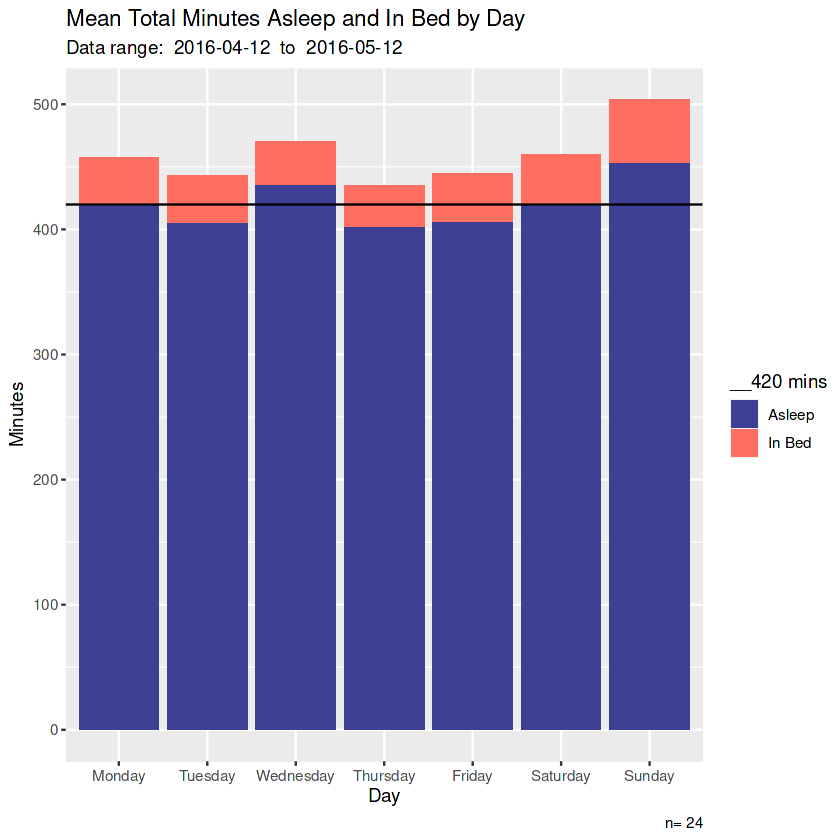

In [18]:
# Reordering the Days so it displays nicer on x-axis
day_order <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")

# Since everyone in data sleeps perfectly at 12 AM (wish that was me), let's analyse days instead of time
sleep_days_grouped <- c_sleep %>%
  mutate(Day = factor(Day, levels = day_order) ) %>%
  group_by(Day) %>%
  summarise(mean_total_mins_asleep = mean(TotalMinutesAsleep),
            mean_total_mins_in_bed = mean(TotalTimeInBed),
            sample_size = n_distinct(Id),
            min_date = min(Date),
            max_date =max(Date))

View(sleep_days_grouped)

ggplot(data = sleep_days_grouped) +
  geom_bar(mapping = aes(x = Day, y = mean_total_mins_in_bed, fill = "In Bed"), stat = "identity", position = "dodge") +
# fill specifies bar figure legend
# stat = 'identity' tells r to take the y value directly from data (data was alr pre-computed when we did summarise() above)
# position = 'dodge' should make the bars side-to-side  

  geom_bar(mapping = aes(x = Day, y = mean_total_mins_asleep, fill = "Asleep"), stat = "identity", position = "dodge") +
  labs(title = "Mean Total Minutes Asleep and In Bed by Day", 
       x = "Day", y = "Minutes", subtitle=(paste('Data range: ',min_date, ' to ', max_date)),
       caption=paste('n=',sample_size)) +
  scale_fill_manual(values = c("In Bed" = "#FF6F61", "Asleep" = "#3E4095")) +
# this changes bar colour

  geom_hline(yintercept = 420) + labs(fill='__420 mins')
# adding a line to show the minimum recommended hours of sleep (7hrs, 420mins)
# fill = '' to hijack legend title to put legend for recommended sleep time 



We see most users get the most time asleep during Sundays (453 mins, 7.55hrs), and have less than 7 hours of sleep during Thursdays (401 mins, 6.68hrs), Tuesday & Friday (405 mins, 6.75hrs).
- Could tailor the watch to user's sleep scheudule and remind them to sleep earlier on days where they get less sleep. 

![](https://momentum-chiro.com/wp-content/uploads/2019/07/Healthysummer.jpg)

# <span style="color:indianred">Summary Conclusions
#### <span style="color:sienna">About User Activity
- Positive correlation between number of steps and calories burned.
- Least activity & lowest time "lightly active" during Sunday 
- Most activity between Tuesday and Saturday.
- Majority of activity in the day starts as early as 5 AM and ends as late as 11 PM.
    - Activity peaked between 5 PM - 7 PM for users.

#### <span style="color:sienna">About User Sleep
- On average, fitbit users spend 16.52 hrs sedentary and have ~7 hrs of sleep daily.
- Users that spent more time sedentary tended to have reduced sleep (and possibly higher weight as shown by preliminary data).
- Those that spent less time in bed also had reduced sleep.
- Users get less than 7hrs sleep on Tuesday, Thursday & Friday. 

# <span style="color:indianred">Limitations
- Demongraphic for fitbit could be very different than demographic for bellabeat due to varying marketing strategies.
- Fairly low sample size when analysing activity (n=33).
- Even lower sample size when looking at sleep (n=24) or weight (n=8).
- Because of the low n size, there was some large variance in some plots. 
- Relevancy concerns. Dataset was updated 3 years ago.
- As such, nothing is too conclusive at this stage.

# <span style="color:indianred">Business Recommendations
- An advantage of this data is the similarity between the fitbit and Bellabeat's Time product. 
- Based on the findings, I'd recommend reminders for users if they spend a prolonged time sedentary
- Sleep reminders, especially on days where users get less than 7hrs 
- Encourage users to spend more time doing light activity over fairly/very active activites, especially on Sunday. 
- Finally, look into why users that are more sedentary spent less time in bed (phone usage?)